## 9. Time Series Forecasting-Ensemble Learning

- https://towardsdatascience.com/time-series-forecasting-ensemble-learning-df5fcbb48581

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

In [2]:
import lightgbm as lgb
import sklearn
from statsmodels.tsa.arima.model import ARIMA

In [3]:
buildings = pd.read_csv('data/ashrae-energy-prediction/building_metadata.csv')
df = pd.read_csv('data/ashrae-energy-prediction/train.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] ==3].reset_index(drop = True) # 3, hotwater 만 추출

In [4]:
buildings['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

모든 데이터가 클린하지 않고 메터가 제대로 없다.  
결측치가 별로 없는 몇개 빌딩만 시각화해보자.

In [8]:
nrows, ncols = 4, 2
building_ids = df['building_id'].value_counts().index[8:16]

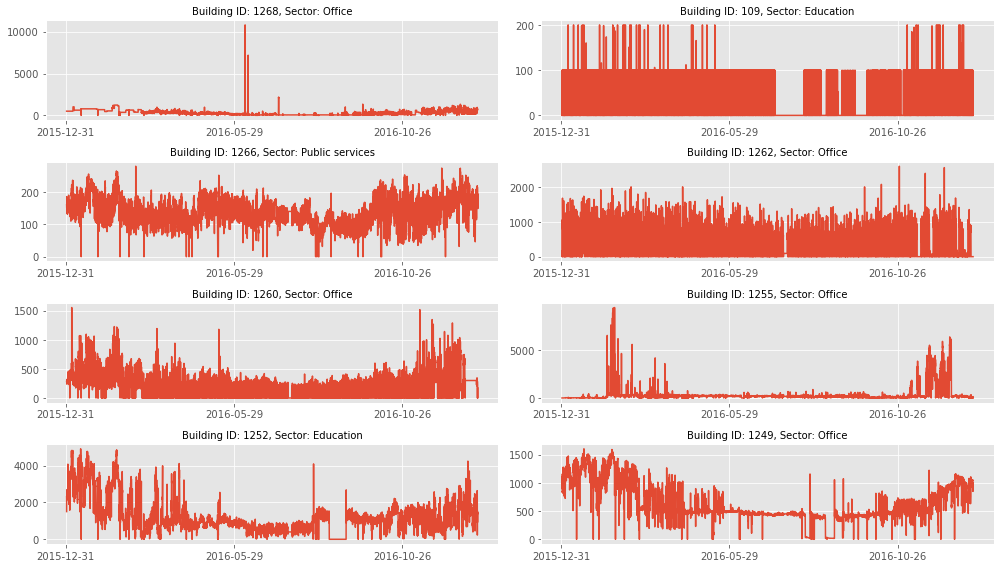

In [14]:
fig, ax = plt.subplots(nrows, ncols, figsize = (14, 8))

for i in range(8):
    # Plotting buildings with most data points
    building_id = building_ids[i]
    sector = buildings[buildings['building_id'] == building_id]['primary_use'].values[0]
    
    plot_data = df[df['building_id'] == building_id][['timestamp','meter','meter_reading']].sort_values('timestamp')
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.plot(plot_data['timestamp'].values, plot_data['meter_reading'].values)
    cax.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax.set_title('Building ID: {}, Sector: {}'.format(building_id, sector), fontsize=10)

plt.tight_layout()
plt.show()

여기서는 building 1266의 water usage를 알아볼 것이다.   
이 데이터는 에러도 좀 있고 장시간 사용이 없는 기록도 있다.

In [20]:
building_id = 1266
sector = buildings[buildings['building_id'] == building_id]['primary_use'].values[0]
building_1034_data = df[df['building_id'] == building_id][['timestamp','meter',
                            'meter_reading']].sort_values('timestamp').reset_index(drop=True)

In [21]:
train, valid = building_1034_data[:-int(len(building_1034_data)*0.10)], \
                building_1034_data[-int(len(building_1034_data)*0.10):]

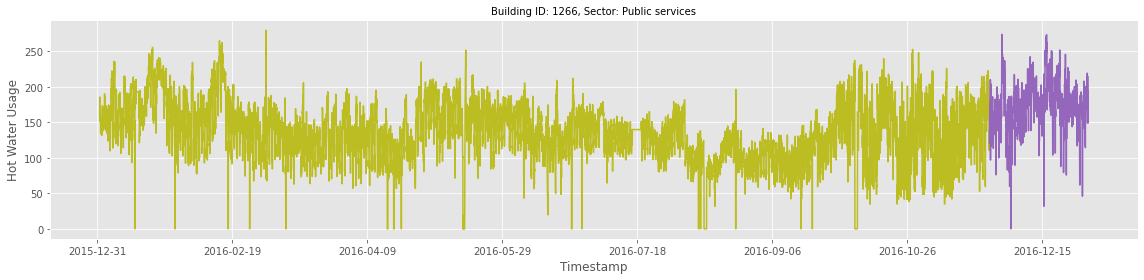

In [22]:
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot(train['timestamp'].values, train['meter_reading'].values, c='tab:olive')
ax1.plot(valid['timestamp'].values, valid['meter_reading'].values, c='tab:purple')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_ylabel('Hot Water Usage')
ax1.set_xlabel('Timestamp')
ax1.set_title('Building ID: {}, Sector: {}'.format(building_id, sector), fontsize=10)

plt.tight_layout()
plt.show()

- 위 결과를 보면 연도별 8~10회의 스파이크가 존재한다. 이는 저온현상과 같은 스페셜 케이스 때문이다. 10~20 포인트의 0 값도 보인다. 휴일 기간인듯하다.    

이제 seasonal 속성을 사용하기 위해 시간 기반 피처를 만들어 보자. 

In [23]:

def add_timestamp_features(data):
    pd.options.mode.chained_assignment = None

    data['day'] = data['timestamp'].dt.day
    data['hour'] = data['timestamp'].dt.hour
    data['dayofweek'] = data['timestamp'].dt.dayofweek
    data['is_month_start'] = data['timestamp'].dt.is_month_start
    data['is_month_end'] = data['timestamp'].dt.is_month_end

    conditions = [(data['dayofweek'].eq(5) | data['dayofweek'].eq(6))]
    choices = [1]
    data['is_weekend'] = np.select(conditions, choices, default=0)
    return data

In [24]:
train = add_timestamp_features(train)

In [25]:
train.head()

,timestamp,meter,meter_reading,day,hour,dayofweek,is_month_start,is_month_end,is_weekend
0,2016-01-01 00:00:00,3,160.230,1,0,4,True,False,0
1,2016-01-01 01:00:00,3,156.015,1,1,4,True,False,0
2,2016-01-01 02:00:00,3,150.957,1,2,4,True,False,0
3,2016-01-01 03:00:00,3,155.155,1,3,4,True,False,0
4,2016-01-01 04:00:00,3,185.648,1,4,4,True,False,0


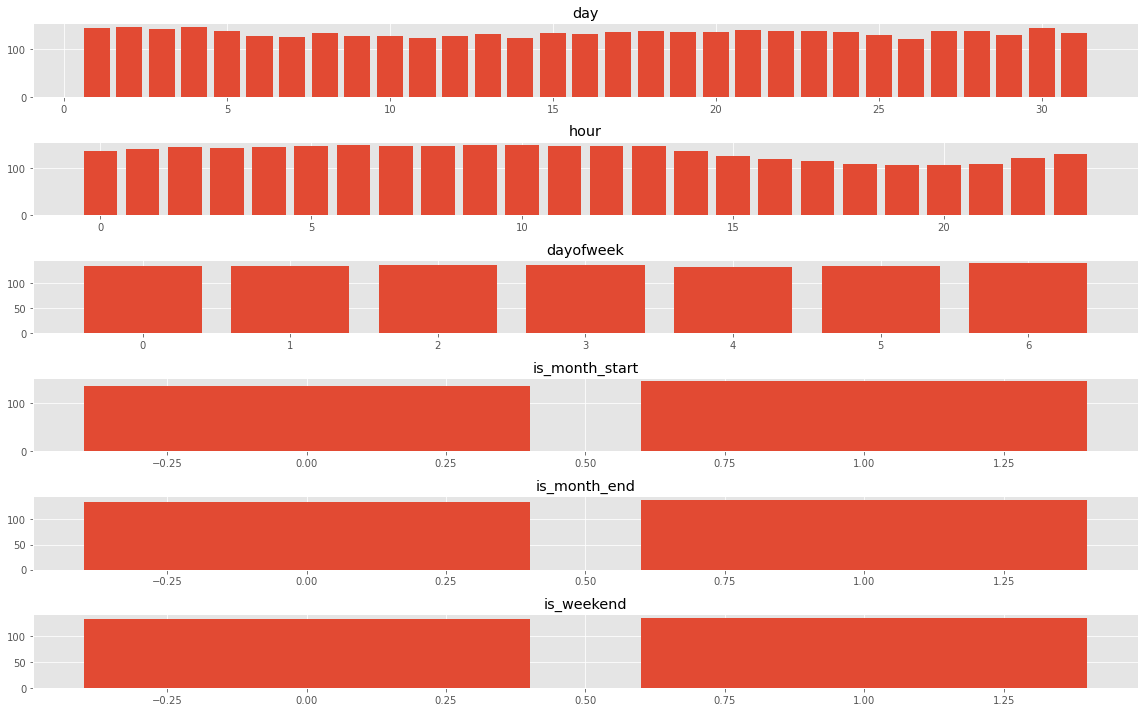

In [26]:
nrows, ncols = 6,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day','hour','dayofweek','is_month_start','is_month_end','is_weekend']):
    
    plot_data = train.groupby(col)['meter_reading'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

### Baseline LGBM Model

In [27]:
valid = add_timestamp_features(valid)

x_train, y_train = train.drop(columns=['meter_reading']), train['meter_reading'].values
x_valid, y_valid = valid.drop(columns=['meter_reading']), valid['meter_reading'].values

In [29]:
params = {'num_leaves': 30,
          'n_estimators': 400,
          'max_depth': 8,
          'min_child_samples': 200,
          'learning_rate': 0.1,
          'subsample': 0.50,
          'colsample_bytree': 0.75
         }

In [30]:
x_train

,timestamp,meter,day,hour,dayofweek,is_month_start,is_month_end,is_weekend
0,2016-01-01 00:00:00,3,1,0,4,True,False,0
1,2016-01-01 01:00:00,3,1,1,4,True,False,0
2,2016-01-01 02:00:00,3,1,2,4,True,False,0
3,2016-01-01 03:00:00,3,1,3,4,True,False,0
4,2016-01-01 04:00:00,3,1,4,4,True,False,0
...,...,...,...,...,...,...,...,...
7901,2016-11-25 05:00:00,3,25,5,4,False,False,0
7902,2016-11-25 06:00:00,3,25,6,4,False,False,0
7903,2016-11-25 07:00:00,3,25,7,4,False,False,0
7904,2016-11-25 08:00:00,3,25,8,4,False,False,0


In [31]:
model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['timestamp']), y_train)

In [32]:

def plot_predictions(x_valid, y_valid, valid_preds, building_id, sector):
    
    rmse = sklearn.metrics.mean_squared_error(y_valid, valid_preds, squared=False)
    
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

    ax1 = plt.subplot(nrows, ncols, 1)
    ax1.plot(x_valid['timestamp'].values, y_valid, c='tab:purple')
    ax1.scatter(x_valid['timestamp'].values, valid_preds, s=5, c='#7FB285')
    ax1.set_ylabel('Hot Water Usage')
    ax1.set_xlabel('Timestamp')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

    plt.tight_layout()
    plt.show()

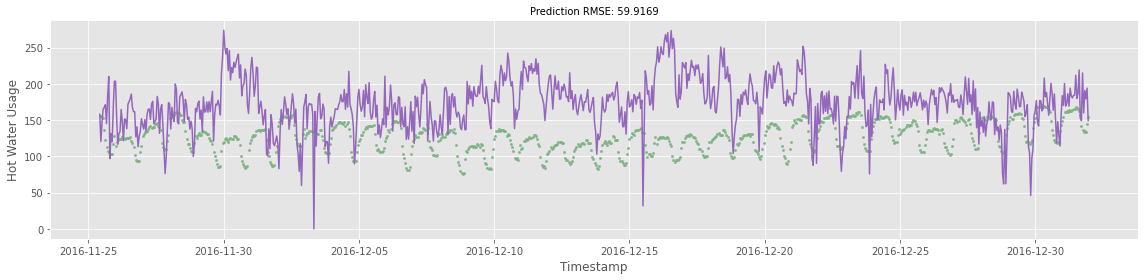

In [33]:
valid_preds = model.predict(x_valid.drop(columns=['timestamp']))    
plot_predictions(x_valid, y_valid, valid_preds, building_id, sector)

### Holiday data 가져와서 개선하기

In [36]:
holidays = pd.read_csv('data/US Holiday Dates (2004-2021).csv')
holidays = holidays[holidays['Year']==2016].sort_values('Date').reset_index(drop=True)

In [37]:
holidays.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2016-01-01,New Year's Day,Friday,1,1,2016
1,2016-01-18,"Martin Luther King, Jr. Day",Monday,1,18,2016
2,2016-02-14,Valentine’s Day,Sunday,2,14,2016
3,2016-02-15,Washington's Birthday,Monday,2,15,2016
4,2016-03-27,Western Easter,Sunday,3,27,2016


In [38]:
x_train['is_holiday'] = x_train['timestamp'].dt.floor('1d').isin(holidays['Date'])
x_valid['is_holiday'] = x_valid['timestamp'].dt.floor('1d').isin(holidays['Date'])

In [39]:
model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['timestamp']), y_train)

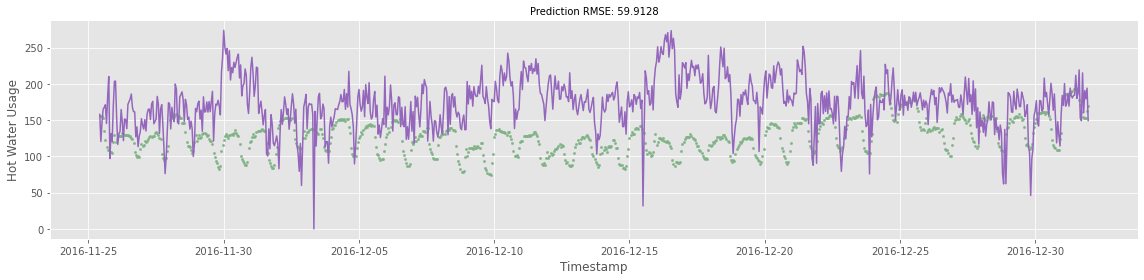

In [40]:
valid_preds = model.predict(x_valid.drop(columns=['timestamp']))    
plot_predictions(x_valid, y_valid, valid_preds, building_id, sector)

- 생각보다 많이 개선되지는 않았다. 그러나 일단 이 피처는 그대로 둔다.

### Weather Data